In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, mean, log1p, when, radians, sin, cos

In [10]:
# Start a Spark session
spark = SparkSession.builder.appName("FRP Prediction").getOrCreate()

# Load the dataset
file_path = "../new_data/processed_data"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Select the columns for features and target
feature_columns = [
    'weather_latitude', 'weather_longitude', 'temperature_2m_max',
    'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max',
    'apparent_temperature_min', 'apparent_temperature_mean', 'daylight_duration',
    'sunshine_duration', 'precipitation_sum', 'rain_sum', 'snowfall_sum',
    'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max',
    'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
    'new_temperature_range', 'new_relative_humidity', 'new_cumulative_precipitation',
    'new_dryness_index', 'new_daylight_fraction', 'new_wind_x', 'new_wind_y',
    'new_soil_moisture', 'new_precip_radiation_ratio'
]
target_column = "brightness"

In [11]:
from pyspark.sql.functions import corr

# Compute correlation of each feature with the target variable
correlations = {}
for column in feature_columns:
    corr_value = data.stat.corr(column, target_column)
    correlations[column] = corr_value

# Convert correlations to a sorted list for analysis
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the correlations
import pandas as pd

correlation_df = pd.DataFrame(sorted_correlations, columns=["Feature", "Correlation with FRP"])
correlation_df_to_display = correlation_df.style.background_gradient(cmap='coolwarm', subset=["Correlation with FRP"])
# Display the correlations locally or save them to a file
correlation_df = pd.DataFrame(sorted_correlations, columns=["Feature", "Correlation with FRP"])

# Save to CSV
correlation_df.to_csv("feature_correlations.csv", index=False)

# Display top correlations
print(correlation_df.head(10))

                      Feature  Correlation with FRP
0  et0_fao_evapotranspiration              0.485006
1          temperature_2m_max              0.484615
2         temperature_2m_mean              0.473115
3    apparent_temperature_max              0.469789
4   apparent_temperature_mean              0.458548
5          temperature_2m_min              0.443846
6    apparent_temperature_min              0.435047
7           sunshine_duration              0.379970
8           new_soil_moisture             -0.376866
9     shortwave_radiation_sum              0.374411


## Linear Regression

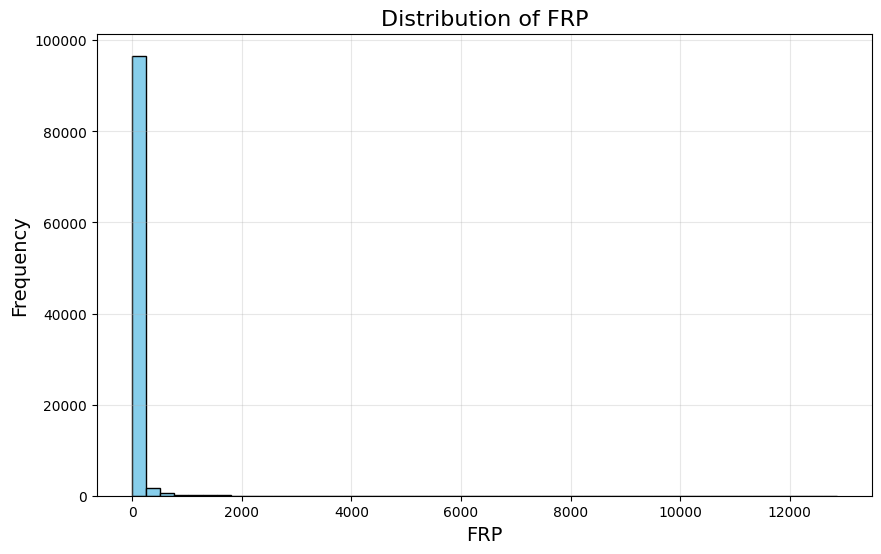

Skewness of FRP: 19.046563855176263
The FRP distribution is significantly right-skewed.


In [12]:
# Convert Spark DataFrame to Pandas DataFrame for histogram visualization
import matplotlib.pyplot as plt
import numpy as np

# Extract 'frp' column from Spark DataFrame
frp_data = data.select('frp').dropna().toPandas()

# Plot histogram of 'frp'
plt.figure(figsize=(10, 6))
plt.hist(frp_data['frp'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of FRP", fontsize=16)
plt.xlabel("FRP", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Calculate skewness of 'frp'
skewness = frp_data['frp'].skew()
print(f"Skewness of FRP: {skewness}")

# Interpret skewness result
if skewness > 1:
    print("The FRP distribution is significantly right-skewed.")
elif skewness > 0.5:
    print("The FRP distribution is moderately right-skewed.")
else:
    print("The FRP distribution is approximately symmetric.")


In [13]:
# Step 1: Handle missing values
mean_values = {col: data.select(mean(col)).collect()[0][0] for col in feature_columns}
data = data.fillna(mean_values)

# Step 2: Add new features
# Temperature range
# data = data.withColumn("temperature_range", col("temperature_2m_max") - col("temperature_2m_min"))

# Wind speed components
# data = data.withColumn("wind_x", col("wind_speed_10m_max") * cos(radians(col("wind_direction_10m_dominant"))))
# data = data.withColumn("wind_y", col("wind_speed_10m_max") * sin(radians(col("wind_direction_10m_dominant"))))
# Precipitation to radiation ratio
# data = data.withColumn("precip_radiation_ratio", when(col("shortwave_radiation_sum") > 0,
#                                                       col("precipitation_sum") / col("shortwave_radiation_sum")).otherwise(0))

In [14]:
data = data.withColumn("log_frp", (col(target_column)))
target_column = "log_frp"

In [15]:
# Split the data into training and test sets
# Step 5: Standardize the features
selected_features = [
    'et0_fao_evapotranspiration', 'temperature_2m_mean', 'temperature_2m_max',
    'apparent_temperature_max', 'apparent_temperature_mean', 'temperature_2m_min',
    'shortwave_radiation_sum', 'apparent_temperature_min', 'new_soil_moisture',
    'sunshine_duration', 'new_temperature_range', 'daylight_duration',
    'new_daylight_fraction'
]
assembler = VectorAssembler(inputCols=selected_features, outputCol="selected_features")
processed_data = assembler.transform(data).select("selected_features", target_column)

processed_data.show(5, truncate=False)
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# data = assembler.transform(data)

scaler = StandardScaler(inputCol="selected_features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(processed_data)
data = scaler_model.transform(processed_data)

# Step 6: Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
# Step 7: Train the Linear Regression model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="scaled_features", labelCol="log_frp", maxIter=100, regParam=0.1)
lr_model = lr.fit(train_data)

+-------------------------------------------------------------------------------------------------------------------------------------------+-------+
|selected_features                                                                                                                          |log_frp|
+-------------------------------------------------------------------------------------------------------------------------------------------+-------+
|[0.22219864,-5.240166,-0.76100004,-4.029381,-8.857232,-7.161,3.38,-11.198456,-3.38,20976.488,6.39999996,27257.41,1135.7254166666667]       |0.0    |
|[0.34514225,-4.7610006,2.239,-1.8268399,-8.954891,-9.761001,3.52,-13.995012,-3.52,21047.875,12.000001000000001,27337.785,1139.074375]      |0.0    |
|[0.26127976,-7.263083,-0.911,-5.079112,-11.705868,-11.061001,3.44,-15.688283,-3.44,21256.86,10.150001,27424.322,1142.6800833333334]        |300.4  |
|[0.35388047,-5.2984996,1.289,-2.609659,-9.732772,-10.261001,3.54,-15.179973,-3.54,21447.717,11.5500

In [16]:
# Make predictions on the training data
train_predictions = lr_model.transform(train_data)

# Initialize the evaluator
evaluator_rmse = RegressionEvaluator(
    labelCol=target_column, predictionCol="prediction", metricName="rmse"
)
evaluator_mae = RegressionEvaluator(
    labelCol=target_column, predictionCol="prediction", metricName="mae"
)

# Compute RMSE and MAE
train_rmse = evaluator_rmse.evaluate(train_predictions)
train_mae = evaluator_mae.evaluate(train_predictions)

# Print the training error
print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(
    labelCol=target_column, predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate R2
evaluator_r2 = RegressionEvaluator(
    labelCol=target_column, predictionCol="prediction", metricName="r2"
)
r2 = evaluator_r2.evaluate(predictions)
print(f"R2: {r2}")
spark.stop()

Training RMSE: 127.6969297636345
Training MAE: 105.46213190094403
Root Mean Squared Error (RMSE): 128.13682735099084
R2: 0.37974136835372585


## Random Forest

In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Start Spark session with optimized configurations
spark = SparkSession.builder \
    .appName("RandomForestRegression") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.service.enabled", "true") \
    .master("local[*]") \
    .getOrCreate()

# Step 2: Load dataset
file_path = "../new_data/processed_data"  # Adjust path as needed
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Data preprocessing
# Select feature columns and target column
feature_columns = [
    'et0_fao_evapotranspiration', 'temperature_2m_mean', 'temperature_2m_max',
    'apparent_temperature_max', 'apparent_temperature_mean', 'temperature_2m_min',
    'shortwave_radiation_sum', 'apparent_temperature_min', 'new_soil_moisture',
    'sunshine_duration', 'new_temperature_range', 'daylight_duration',
    'new_daylight_fraction'
]
target_column = "brightness"
data = data.withColumn("log_brightness", log1p(col(target_column)))
target_column = "log_brightness"
# Remove null values
data = data.na.drop()

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Step 4: Train-test split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Step 5: Train Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol=target_column, seed=42)
rf_model = rf.fit(train_data)

# Step 6: Make predictions
predictions = rf_model.transform(test_data)

# Step 7: Evaluate the model
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2_evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")




Root Mean Squared Error (RMSE): 2.0169023243228708
R2 Score: 0.4893090117197618


In [20]:
from pyspark.sql.functions import expm1

# Step 6.1: Add inverse-transformed predictions and actual values
predictions = predictions.withColumn("original_prediction", expm1("prediction"))
predictions = predictions.withColumn("original_actual", expm1(target_column))

# Step 7.1: Evaluate the model in the original frp domain
original_rmse_evaluator = RegressionEvaluator(
    labelCol="original_actual", predictionCol="original_prediction", metricName="rmse"
)
original_rmse = original_rmse_evaluator.evaluate(predictions)

original_r2_evaluator = RegressionEvaluator(
    labelCol="original_actual", predictionCol="original_prediction", metricName="r2"
)
original_r2 = original_r2_evaluator.evaluate(predictions)

print(f"Original Root Mean Squared Error (RMSE): {original_rmse}")
print(f"Original R2 Score: {original_r2}")
# Stop Spark session
spark.stop()

Original Root Mean Squared Error (RMSE): 156.46988144327486
Original R2 Score: 0.0724306002847821


## XGBoost

In [21]:
import pandas as pd

# Load the given feature importance data
file_path = "/mnt/data/image.png"  # Replace this with the actual text extraction if needed

# Sample features used in the earlier code
earlier_features = [
    'et0_fao_evapotranspiration', 'temperature_2m_mean', 'temperature_2m_max',
    'apparent_temperature_max', 'apparent_temperature_mean', 'temperature_2m_min',
    'shortwave_radiation_sum', 'apparent_temperature_min', 'new_soil_moisture',
    'sunshine_duration', 'new_temperature_range', 'daylight_duration',
    'new_daylight_fraction'
]

# Assume extracted features from the importance analysis are saved as follows
important_features = [
    'apparent_temperature_mean', 'shortwave_radiation_sum', 'precipitation_hours',
    'new_cumulative_precipitation', 'snowfall_sum', 'wind_direction_10m_dominant',
    'new_relative_humidity', 'latitude', 'et0_fao_evapotranspiration',
    'wind_speed_10m_max', 'sunshine_duration', 'wind_gusts_10m_max',
    'apparent_temperature_min', 'new_dryness_index', 'new_temperature_range',
    'new_fire_intensity', 'longitude', 'daylight_duration', 'new_wind_x',
    'rain_sum', 'new_wind_y', 'precipitation_sum', 'new_daylight_fraction',
    'new_fire_risk', 'new_precip_radiation_ratio', 'apparent_temperature_max',
    'temperature_2m_max', 'temperature_2m_min', 'weather_longitude',
    'temperature_2m_mean', 'new_soil_moisture', 'weather_latitude'
]

# Find the intersection of features
intersecting_features = list(set(earlier_features) & set(important_features))
intersecting_features


['temperature_2m_min',
 'new_soil_moisture',
 'daylight_duration',
 'shortwave_radiation_sum',
 'apparent_temperature_min',
 'apparent_temperature_max',
 'apparent_temperature_mean',
 'new_temperature_range',
 'new_daylight_fraction',
 'temperature_2m_max',
 'et0_fao_evapotranspiration',
 'sunshine_duration',
 'temperature_2m_mean']

In [26]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("XGBoostRegression") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

# Step 2: Load dataset
file_path = "../new_data/processed_data"  # Update the path to your dataset
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Select the common features from the provided list
selected_features = [
    'apparent_temperature_mean', 'shortwave_radiation_sum', 'precipitation_hours',
    'new_cumulative_precipitation', 'snowfall_sum', 'wind_direction_10m_dominant',
    'new_relative_humidity', 'et0_fao_evapotranspiration', 'wind_speed_10m_max',
    'sunshine_duration', 'wind_gusts_10m_max', 'apparent_temperature_min',
    'new_dryness_index', 'new_temperature_range', 'longitude', 'daylight_duration',
    'new_wind_x', 'rain_sum', 'new_wind_y', 'precipitation_sum'
]
target_column = "confidence"  # Target column for prediction

# Step 4: Filter data
data = data.select(*selected_features, target_column)

# Step 5: Remove null values
data = data.na.drop()

# Step 6: Convert Spark DataFrame to Pandas DataFrame
pandas_data = data.toPandas()

# Step 7: Define features (X) and target (y)
X = pandas_data[selected_features]
y = pandas_data[target_column]

# Step 8: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Step 10: Make predictions
y_pred = xgb_model.predict(X_test)

# Step 11: Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")

# Stop the Spark session
spark.stop()


Root Mean Squared Error (RMSE): 15.639044668331405
R2 Score: 0.8369477987289429


### Normalization Added

In [29]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("XGBoostRegression") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

# Step 2: Load dataset
file_path = "../new_data/processed_data"  # Update the path to your dataset
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Select the common features from the provided list
selected_features = [
    'apparent_temperature_mean', 'shortwave_radiation_sum', 'precipitation_hours',
    'new_cumulative_precipitation', 'snowfall_sum', 'wind_direction_10m_dominant',
    'new_relative_humidity', 'et0_fao_evapotranspiration', 'wind_speed_10m_max',
    'sunshine_duration', 'wind_gusts_10m_max', 'apparent_temperature_min',
    'new_dryness_index', 'new_temperature_range', 'longitude', 'daylight_duration',
    'new_wind_x', 'rain_sum', 'new_wind_y', 'precipitation_sum'
]
target_column = "confidence"  # Target column for prediction

# Step 4: Filter data
data = data.select(*selected_features, target_column)

# Step 5: Remove null values
data = data.na.drop()

# Step 6: Convert Spark DataFrame to Pandas DataFrame
pandas_data = data.toPandas()

# Step 7: Define features (X) and target (y)
X = pandas_data[selected_features]
y = pandas_data[target_column]

# Step 8: Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)  # Normalize all features to [0, 1]

# Step 9: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Step 10: Train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,        # Number of trees
    max_depth=6,             # Maximum tree depth
    learning_rate=0.1,       # Learning rate
    subsample=0.8,           # Subsample ratio
    colsample_bytree=0.8,    # Column sample ratio
    random_state=42          # Random state for reproducibility
)

xgb_model.fit(X_train, y_train)

# Step 11: Make predictions
y_pred = xgb_model.predict(X_test)

# Step 12: Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")

# Stop the Spark session
spark.stop()


Root Mean Squared Error (RMSE): 15.626645994142617
R2 Score: 0.837206244468689


## LightGBM

In [27]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("LightGBMRegression") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

# Step 2: Load dataset
file_path = "../new_data/processed_data"  # Update the path to your dataset
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Select the common features from the provided list
selected_features = [
    'apparent_temperature_mean', 'shortwave_radiation_sum', 'precipitation_hours',
    'new_cumulative_precipitation', 'snowfall_sum', 'wind_direction_10m_dominant',
    'new_relative_humidity', 'et0_fao_evapotranspiration', 'wind_speed_10m_max',
    'sunshine_duration', 'wind_gusts_10m_max', 'apparent_temperature_min',
    'new_dryness_index', 'new_temperature_range', 'longitude', 'daylight_duration',
    'new_wind_x', 'rain_sum', 'new_wind_y', 'precipitation_sum'
]
target_column = "confidence"  # Target column for prediction

# Step 4: Filter data
data = data.select(*selected_features, target_column)

# Step 5: Remove null values
data = data.na.drop()

# Step 6: Convert Spark DataFrame to Pandas DataFrame
pandas_data = data.toPandas()

# Step 7: Define features (X) and target (y)
X = pandas_data[selected_features]
y = pandas_data[target_column]

# Step 8: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train the LightGBM model
lgbm_model = LGBMRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train, y_train)

# Step 10: Make predictions
y_pred = lgbm_model.predict(X_test)

# Step 11: Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")

# Stop the Spark session
spark.stop()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4870
[LightGBM] [Info] Number of data points in the train set: 79741, number of used features: 20
[LightGBM] [Info] Start training from score 27.477822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor

# Step 1: Load the data
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("StratifiedModeling") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load the dataset from a CSV file
file_path = "../new_data/processed_data"  # Adjust file path as needed
data_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert the Spark DataFrame to a Pandas DataFrame
data = data_spark.toPandas()

# Step 2: Feature selection and preprocessing
selected_features = [
    'et0_fao_evapotranspiration', 'temperature_2m_mean', 
    'shortwave_radiation_sum', 'apparent_temperature_min', 'new_soil_moisture',
    'sunshine_duration', 'new_temperature_range', 'daylight_duration',
    'new_daylight_fraction', 'new_cumulative_precipitation'
]  # Replace with your desired feature list

classification_target = "in_modis"  # Whether a fire occurred
regression_target = "frp"           # Fire intensity (target for regression)

# Ensure there are no null values in selected features
data = data.dropna(subset=selected_features + [classification_target, regression_target])

# Step 3: Splitting the data
X = data[selected_features]
y_classification = data[classification_target]
y_regression = data[regression_target]

X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_classification, y_regression, test_size=0.2, random_state=42
)

# Step 4: Train the classification model (Predicting fire occurrence)
clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train_class)

# Predict classification
y_pred_class = clf.predict(X_test)
classification_accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Classification Accuracy: {classification_accuracy:.4f}")

# Step 5: Train the regression model (Predicting fire intensity for fire samples)
X_train_reg = X_train[y_train_class == 1]  # Select only samples with fire occurrence
y_train_reg = y_train_reg[y_train_class == 1]

X_test_reg = X_test[y_test_class == 1]  # Select only samples with fire occurrence in the test set
y_test_reg = y_test_reg[y_test_class == 1]

reg = LGBMRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predict regression
y_pred_reg = reg.predict(X_test_reg)
rmse_regression = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"Regression RMSE (for fire samples): {rmse_regression:.4f}")

# Step 6: Combine the results
y_pred_combined = np.zeros(len(X_test))  # Initialize predictions to 0
y_pred_combined[y_test_class == 1] = y_pred_reg  # Replace fire samples with regression predictions

rmse_combined = np.sqrt(mean_squared_error(y_test_reg, y_pred_combined[y_test_class == 1]))
print(f"Combined RMSE (all samples): {rmse_combined:.4f}")

# Stop Spark session
spark.stop()

[LightGBM] [Info] Number of positive: 30421, number of negative: 49321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 79742, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381493 -> initscore=-0.483217
[LightGBM] [Info] Start training from score -0.483217
Classification Accuracy: 0.9049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2541
[LightGBM] [Info] Number of data points in the train set: 30421, number of used features: 10
[LightGBM] [Info] Start training from score 108.553223
Regression RMSE (for fire samples): 312.3439
Combined RMSE (all samples): 312.3439
